In [1]:
from utils.data_utils import split_dataset, TimeSeriesDataset
from utils.evaluation_utils import plot_multistep_forecast, evaluate_on_test_data
from utils.training_utils import train
import pandas as pd 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

/home/codespace/.python/current/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [48]:
ETTm2 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm2.csv")
training_df, val_df, test_df = split_dataset(ETTm2, remain_same = False)

ETTm2.OT.plot()

In [49]:
undiff_train_OT = training_df.OT 
undiff_val_OT = val_df.OT 
undiff_test_OT = test_df.OT

training_df['OT']= training_df.OT.diff(1)
val_df['OT'] = val_df.OT.diff(1)
test_df['OT'] = test_df.OT.diff(1)

<Axes: >

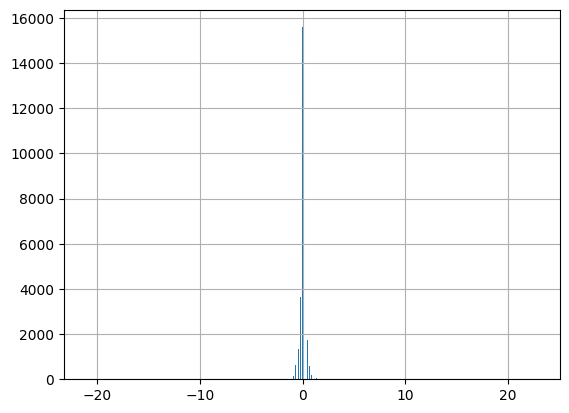

In [62]:
training_df.OT.hist(bins = 1000)

In [103]:
p_lag = 96
future_steps = round(48)
batch_size = 8
epochs = 1
learning_rate=1.e-4
decomp_kernel_size = 24
number_of_forecasts = 100
target_column = ['OT']
feature_columns = [i for i in training_df.columns]

In [104]:
net, res = train(
            epochs = epochs, 
            n_continous_features=7, 
            n_categorial_features=5,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df.iloc[1:,:], 
            validation_df = val_df.iloc[1:,:], 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            get_residuals = True, 
            model = 'rmlp'
            )

Random seed set as 42
RMLP activated
Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 5000 : 2.7902268012046814
Current (running) training loss at iteration 10000 : 1.8682918664574624
Current (running) training loss at iteration 15000 : 1.4217838177760442
Current (running) training loss at iteration 20000 : 1.140250539547205
Current (running) training loss at iteration 25000 : 0.9750608338165283
Current (running) training loss at iteration 30000 : 0.869067165718476

Epoch 0: 

Train metrics: -------
Running (training) loss is 0.8120792976379175.
Training MAE is 0.21816490914495787.
Training MSE is 0.812936789364928.
Training MAPE is 91867225395.0122.

Val metrics: -------
Running (validation) loss is 0.21809982435295822.
Validation MAE is 0.12902113182154434.
Validation MSE is 0.2185706823716527.
Validation MAPE is 54864280284.68359.
---------------------------


In [105]:
test_data = DataLoader(TimeSeriesDataset(test_df.iloc[1:,:],future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)

In [118]:
for i, (input, targets) in enumerate(test_data): 
    if i == 50: 
        break
    else: 
        predictions = net(input)

In [119]:
idx = i - 1
skip = idx*batch_size
batch_idx = 8
pred = predictions[(batch_idx-1),:].tolist()
targets = undiff_test_OT.tolist()[(skip + batch_idx-1):(future_steps+skip +batch_idx+1)]
undiff_pred_l = []
undiff_truth_l = []
for i in range(future_steps):
    if i == 0:  
        x_hat_i = pred[i]
        x_i_minus_1 = targets[i]
        undiff_pred = x_hat_i + x_i_minus_1
    else: 
        x_hat_i = pred[i]
        x_i_minus_1 = undiff_pred
        undiff_pred = x_hat_i + x_i_minus_1
        
    undiff_truth = targets[i+1]
    undiff_pred_l.append(undiff_pred)
    undiff_truth_l.append(undiff_truth)

In [120]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(undiff_truth_l,undiff_pred_l) 

951.1835033114917

In [41]:
import matplotlib.pyplot as plt 

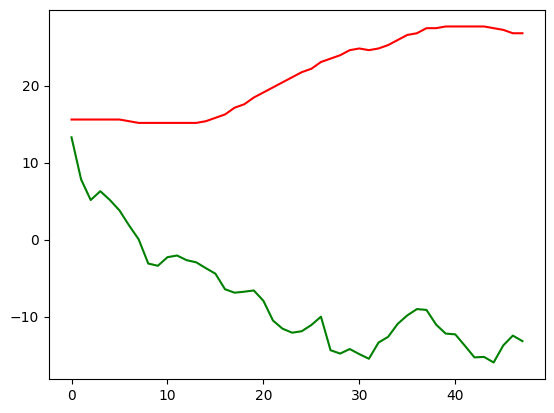

In [121]:
plt.plot(undiff_pred_l,'g', undiff_truth_l, 'r')